In [72]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [107]:
def MA(X, mu, theta, order):
    T = len(X)

    res = np.zeros(T)
    eps = X - mu

    for t in range(T):
        if t < order:
            res[t] = mu + eps[t]
        else:
            res[t] = mu + np.dot(theta,eps[t-order:t][::-1])
    return res

In [108]:
def ma_neg_log_likelihood(params, X, order):
    mu = params[0]
    theta = params[1:order+1]
    sigma2 = params[-1]**2

    T = len(X)
    eps = np.zeros(T)

    
    
    for t in range(T):
        if t < order:
            eps[t] = X[t] - mu
        else:
            
            
            eps[t] = X[t] - mu - np.dot(theta,eps[t-order:t][::-1])
        
    nll = T/2*np.log(2*np.pi*sigma2) + 1/2/sigma2*np.sum(eps**2)

    return nll

In [97]:
def fit_ma_model(X, order):
    mu_seed = np.mean(X)
    sigma_seed = np.std(X)
    rng = np.random.default_rng(seed=42)
    theta_seed = rng.random(size=order)*0.1

    params_init = np.concatenate(([mu_seed], theta_seed, [sigma_seed]))

    params_bounds = [(-1e2, 1e2)] * (order + 1) + [(1e-7, np.inf)]
    #print(params_init)
    result = minimize(ma_neg_log_likelihood,
                      params_init,
                      bounds = params_bounds,
                      args=(X,order),
                       method='L-BFGS-B')
    return result.x[0], result.x[1:order+1], result.x[-1]
    
    

In [5]:
x_train = pd.read_csv('./x_train.csv', index_col='ID')
y_train = pd.read_csv('./y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1).dropna()
test = pd.read_csv('./x_test.csv', index_col='ID').dropna()

In [6]:
series = x_train[x_train['DATE']==0]
series = series[series['STOCK']==2]
cols_idx = ['RET_%i' % i for i in range(1,21)]
series = series[cols_idx]

In [7]:
series.head()

,RET_1,RET_2,RET_3,RET_4,RET_5,RET_6,RET_7,RET_8,RET_9,RET_10,RET_11,RET_12,RET_13,RET_14,RET_15,RET_16,RET_17,RET_18,RET_19,RET_20
ID,,,,,,,,,,,,,,,,,,,,
0,-0.015748,-0.015504,0.010972,-0.014672,0.016483,0.014331,-0.017215,-0.018433,0.134146,0.182287,0.01357,0.030108,0.027624,-0.04937,-0.028571,0.059459,0.003254,0.008752,-0.012959,-0.002155


In [121]:
order = 10
#signal = series.values[0,-order:]
signal = series.values[0,:]
mu = np.mean(signal)
np.random.seed(10219321)
sigma = np.std(signal)
eps = signal - sigma
rng = np.random.default_rng(seed=42)
theta = rng.random(size=order)*0.1
params = [mu,*theta,sigma]

In [122]:
ma_neg_log_likelihood(params,signal,order)

-30.25732611743676

In [123]:
mu, theta, sigma = fit_ma_model(signal,order)

[0.016318   0.0773956  0.04388784 0.08585979 0.0697368  0.00941773
 0.09756224 0.07611397 0.07860643 0.01281136 0.04503859 0.05326248]


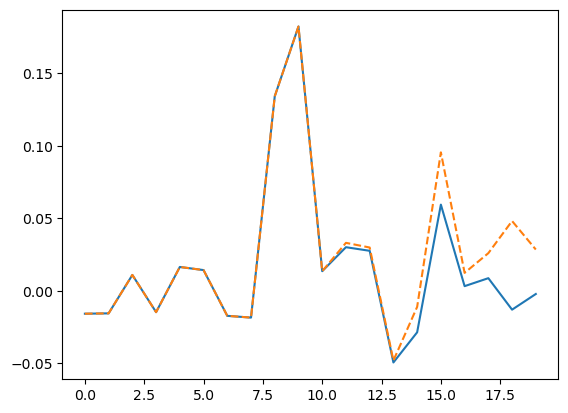

In [124]:
fig, ax = plt.subplots()
ax.plot(signal)
ax.plot(MA(signal, mu, theta, order),'--')

In [115]:
theta

array([-0.39846293, -0.88168029, -1.63286054, -1.0555211 , -0.95282548])

In [116]:
theta[1:-1][::-1]

array([-1.0555211 , -1.63286054, -0.88168029])

In [131]:
mu + np.dot(theta,signal[-order:])

0.05463215863316775

In [129]:
y_train

,RET
ID,
0,True
1,True
2,False
3,False
4,False
...,...
418590,False
418591,False
418592,True
